In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew 
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import squarify

import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go 

from sklearn.preprocessing import LabelEncoder

from typing import List
import itertools

%matplotlib inline
plt.style.use('fivethirtyeight')
init_notebook_mode(connected=True)
sns.set_style("whitegrid")
sns.set_context("paper")

pd.set_option("display.max_columns", None)

In [2]:
!pip install -q feature-engine

### Helper Functions

In [3]:
def DataDesc(df: pd.DataFrame) -> pd.DataFrame:
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    return summary


def Null_Count(df : pd.DataFrame) -> pd.DataFrame:
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]


def plot_feature_vs_target(df : pd.DataFrame, feature: str):
    group = df.groupby([feature,'is_canceled']).size().rename('Count').reset_index() 
    fig  = px.histogram(group, 
              x=feature, 
              y='Count',
              color='is_canceled',
              color_discrete_sequence=["#457b9d","#fca311"],
              template='plotly_white')

    fig.update_layout(width=900, height=400, 
                      barmode='group',
                      title= {'text': f"{feature} vs Cancellation",
                              'y':0.95,'x':0.5,
                              'xanchor': 'center',
                              'yanchor': 'top'},
                     showlegend=True,
                     margin = dict(l=25, r=10, t=50, b=10))
                 
                 
    fig.show()
    
    # Calculate Rate of cancellations
    df_ratio = pd.DataFrame()
    ratio = list()
    values = group[feature].unique()
    for val in values:
        try:
            cancelled = group.query(f"is_canceled == 1 and {feature} == '{val}'")['Count'].values[0]
        except:
            cancelled = 0
        try:
            confirmed = group.query(f"is_canceled == 0 and {feature} == '{val}'")['Count'].values[0]
        except:
            confirmed = 0
        
        ratio.append(cancelled/(cancelled+confirmed))

    df_ratio['values'] = values
    df_ratio['Rate of Cancellation'] = ratio   

    print('')
    print('Cancellation Rate')
    display(df_ratio.sort_values(by='Rate of Cancellation', ascending=False))
    
    
    
    
#correlation heatmap of dataset
def correlation_heatmap(df: pd.DataFrame):
    _ , ax = plt.subplots(figsize =(20, 30))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':0.5 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':15 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=30)
    

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Reading Data

In [4]:
PATH = '../input/hotel-bookings/hotel_bookings (Assignment).csv'

df_hotel = pd.read_csv(PATH)

df_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
df_hotel.sample(7, random_state=10)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
2125,Resort Hotel,0,46,2015,October,40,2,2,5,2,0.0,0,BB,NLD,Offline TA/TO,TA/TO,0,0,0,D,D,1,No Deposit,71.0,NaN,0,Transient,55.43,0,0,Check-Out,2015-10-09
84565,City Hotel,0,6,2016,February,9,25,0,3,2,0.0,0,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,20.0,NaN,0,Transient,62.00,0,1,Check-Out,2016-02-28
84972,City Hotel,0,4,2016,March,11,6,1,0,2,0.0,0,BB,BRA,Groups,TA/TO,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,82.00,0,0,Check-Out,2016-03-07
43746,City Hotel,0,86,2015,September,39,24,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,B,1,No Deposit,12.0,NaN,0,Transient-Party,87.50,0,0,Check-Out,2015-09-26
64881,City Hotel,1,13,2017,March,12,19,2,0,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,118.00,0,0,Canceled,2017-03-07
60306,City Hotel,1,277,2016,November,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NaN,NaN,0,Transient,100.00,0,0,Canceled,2016-04-04
26451,Resort Hotel,0,65,2016,July,31,29,1,2,2,0.0,0,BB,FIN,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,242.0,NaN,0,Transient,192.67,0,1,Check-Out,2016-08-01


## 2. Exploring different Features

### i. Columns : Unique, Missing values

In [6]:
DataDesc(df_hotel)

Dataset Shape: (119390, 32)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,hotel,object,0,2,Resort Hotel,Resort Hotel,Resort Hotel,0.92
1,is_canceled,int64,0,2,0,0,0,0.95
2,lead_time,int64,0,479,342,737,7,7.95
3,arrival_date_year,int64,0,3,2015,2015,2015,1.49
4,arrival_date_month,object,0,12,July,July,July,3.54
5,arrival_date_week_number,int64,0,53,27,27,27,5.68
6,arrival_date_day_of_month,int64,0,31,1,1,1,4.95
7,stays_in_weekend_nights,int64,0,17,0,0,0,1.73
8,stays_in_week_nights,int64,0,35,0,0,1,2.63
9,adults,int64,0,14,2,2,1,1.03


### ii. Columns with null values

In [7]:
Null_Count(df_hotel)

,Column,Null_Count,Null_Percent
0,company,112593,94.306893
1,agent,16340,13.686238
2,country,488,0.408744
3,children,4,0.003350


### Exploring - Company

<AxesSubplot:xlabel='company', ylabel='Density'>

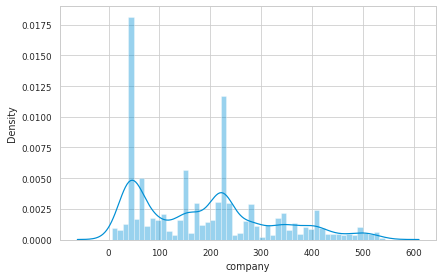

In [8]:
sns.distplot(df_hotel[~df_hotel.company.isnull()].company, bins=50)

The company values peak at ranges 50, 230

### Distributuon of company vs cancellation

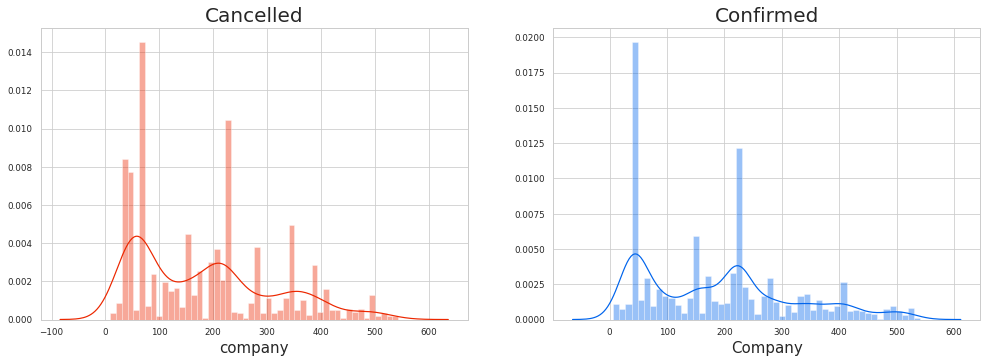

In [9]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
_ = sns.distplot(df_hotel[~df_hotel.company.isnull()].query("is_canceled == 1")["company"], bins=50, color='#EC2700', ax=ax1)
_ = ax1.set_title('Cancelled', fontsize=20)
_ = ax1.set_xlabel("company",fontsize=15)
_ = ax1.set_ylabel("")

ax2 = fig.add_subplot(122)
_ = sns.distplot(df_hotel[~df_hotel.company.isnull()].query("is_canceled == 0")["company"], bins=50, color='#0064EC', ax=ax2)
_ = ax2.set_title('Confirmed', fontsize=20)
_ = ax2.set_xlabel("Company",fontsize=15)
_ = ax2.set_ylabel("")

From the above, we see that the distributions are somewhat similar in both the cases.<br>
Company values for ranges 40,70,210,350,380 have very high cancellations as compared to confirmation.<br>
Values for range 50 show very high confirmations as compared to cancellations

### Exploring Agent

<AxesSubplot:xlabel='agent', ylabel='Density'>

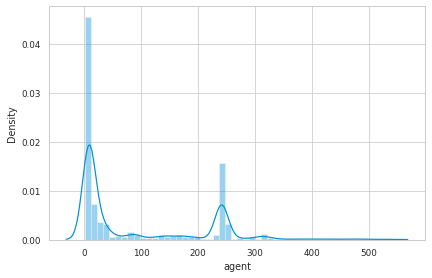

In [10]:
sns.distplot(df_hotel[~df_hotel.agent.isnull()].agent)

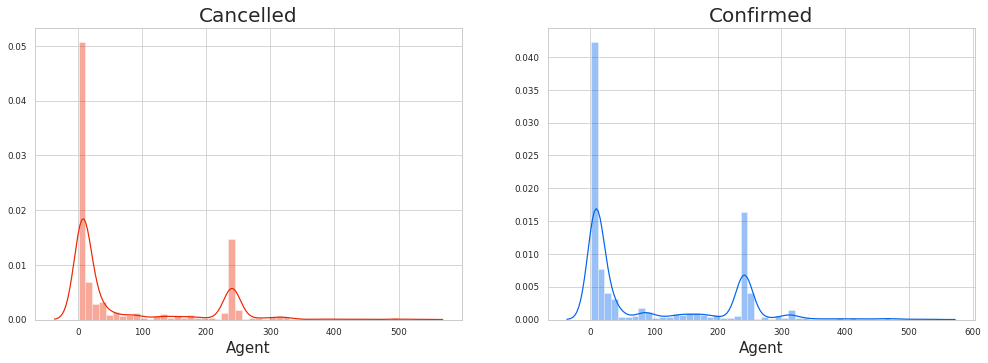

In [11]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
_ = sns.distplot(df_hotel[~df_hotel.agent.isnull()].query("is_canceled == 1")["agent"], bins=50, color='#EC2700', ax=ax1)
_ = ax1.set_title('Cancelled', fontsize=20)
_ = ax1.set_xlabel("Agent",fontsize=15)
_ = ax1.set_ylabel("")

ax2 = fig.add_subplot(122)
_ = sns.distplot(df_hotel[~df_hotel.agent.isnull()].query("is_canceled == 0")["agent"], bins=50, color='#0064EC', ax=ax2)
_ = ax2.set_title('Confirmed', fontsize=20)
_ = ax2.set_xlabel("Agent",fontsize=15)
_ = ax2.set_ylabel("")

Distributions for cancelled & confirmations are very similar for feature Agent

### Analyzing Reservation Status, Arrival Date & Cancellations

Strafied Sampling Based on Reservation status

In [12]:
df_hotel[['arrival_date_month','arrival_date_day_of_month', 'reservation_status_date', 'reservation_status']].groupby('reservation_status', group_keys=False)\
                                .apply(lambda x: x.sample(4))

,arrival_date_month,arrival_date_day_of_month,reservation_status_date,reservation_status
10751,March,31,2017-01-23,Canceled
54461,July,16,2016-07-03,Canceled
5702,May,11,2015-11-04,Canceled
67067,April,28,2016-10-27,Canceled
96458,September,2,2016-09-03,Check-Out
88253,April,26,2016-05-03,Check-Out
20672,February,6,2016-02-07,Check-Out
23719,April,30,2016-05-02,Check-Out
80920,November,28,2015-11-28,No-Show
8719,October,11,2016-10-11,No-Show


In [13]:
display(df_hotel.groupby(['is_canceled','reservation_status']).size().rename('Count').reset_index())

,is_canceled,reservation_status,Count
0,0,Check-Out,75166
1,1,Canceled,43017
2,1,No-Show,1207


We can clearly see that Reservation status(Canceled & No-show) correspond to Target variable is_canceled, <br>hence we need to drop features reservation_status & reservation_status_date

### Comparison of Categorical features with target.
#### Cancellation Rate
#### Hotel

In [14]:
plot_feature_vs_target(df_hotel, 'hotel')


Cancellation Rate


,values,Rate of Cancellation
0,City Hotel,0.417270
1,Resort Hotel,0.277634


We can see that for City hotel the ratio of cancellation-Confirmation is higher(40%) as comapred to Resort hotel(20%)

In [15]:
plot_feature_vs_target(df_hotel, 'customer_type')


Cancellation Rate


,values,Rate of Cancellation
2,Transient,0.407463
0,Contract,0.309617
3,Transient-Party,0.254299
1,Group,0.102253


In [16]:
plot_feature_vs_target(df_hotel, 'deposit_type')


Cancellation Rate


,values,Rate of Cancellation
1,Non Refund,0.993624
0,No Deposit,0.283770
2,Refundable,0.222222


Deposit Type: Non Refund, has extremely high cancellation rates more than 99%

In [17]:
plot_feature_vs_target(df_hotel, 'distribution_channel')


Cancellation Rate


,values,Rate of Cancellation
4,Undefined,0.800000
3,TA/TO,0.410259
0,Corporate,0.220758
2,GDS,0.191710
1,Direct,0.174599


In [18]:
plot_feature_vs_target(df_hotel, 'market_segment')


Cancellation Rate


,values,Rate of Cancellation
7,Undefined,1.000000
4,Groups,0.610620
6,Online TA,0.367211
5,Offline TA/TO,0.343160
0,Aviation,0.219409
2,Corporate,0.187347
3,Direct,0.153419
1,Complementary,0.130552


In [19]:
plot_feature_vs_target(df_hotel, 'assigned_room_type')


Cancellation Rate


,values,Rate of Cancellation
10,L,1.000000
11,P,1.000000
0,A,0.444925
7,H,0.352528
6,G,0.305523
4,E,0.252114
3,D,0.251244
5,F,0.247134
1,B,0.236708
2,C,0.187789


In [20]:
plot_feature_vs_target(df_hotel, 'arrival_date_month')


Cancellation Rate


,values,Rate of Cancellation
6,June,0.414572
0,April,0.407972
8,May,0.396658
11,September,0.391702
10,October,0.380466
1,August,0.377531
5,July,0.374536
2,December,0.349705
3,February,0.334160
7,March,0.321523


Feature Month does not really impact the cancellation as <br>all the months have similar cancellationrates

### Class Distribution

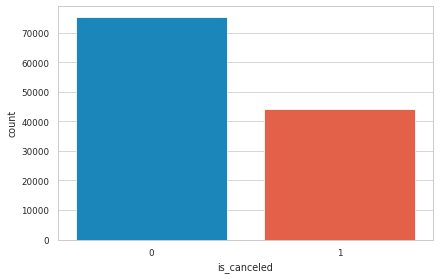

In [21]:
_ = sns.countplot(df_hotel['is_canceled'])

Our Focus would be on Cancellations(Minority class), while training the models

### 3. Feature Selection

In [22]:
# Creating a copy of original dataframe for feature selection analysis
df = df_hotel.copy()

# Dropping company as 94% data is missing
df.drop(['reservation_status', 'reservation_status_date', 'company'], axis=1, inplace=True)
df['country'].fillna('Missing', inplace=True)
df['agent'].fillna(df['agent'].median(), inplace=True)
df.dropna(axis=0, inplace=True)


"""
median_canceled = df.groupby(['is_canceled'])['company'].agg('median').values[0]
median_confirmed = df.groupby(['is_canceled'])['company'].agg('median').values[1]

def impute_median(values):    
    is_canceled = values[0]
    company = values[1]
    
    if not company:
        if is_canceled == 1:
            return median_canceled
        else:
            return median_confirmed

    return company"""
    
# df['company'] = df[['is_canceled', 'company']].apply(impute_company_median, axis=1)

"\nmedian_canceled = df.groupby(['is_canceled'])['company'].agg('median').values[0]\nmedian_confirmed = df.groupby(['is_canceled'])['company'].agg('median').values[1]\n\ndef impute_median(values):    \n    is_canceled = values[0]\n    company = values[1]\n    \n    if not company:\n        if is_canceled == 1:\n            return median_canceled\n        else:\n            return median_confirmed\n\n    return company"

### Confirming if any null values

In [23]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

In [24]:
NUMERICAL_COLS = df.columns[df.dtypes != 'object']
CATEGORICAL_COLS = df.columns[df.dtypes == 'object']

In [25]:
# Label Encoding
le = LabelEncoder()

df[CATEGORICAL_COLS] = df[CATEGORICAL_COLS].apply(le.fit_transform)

### Correlation Between Numerical Features

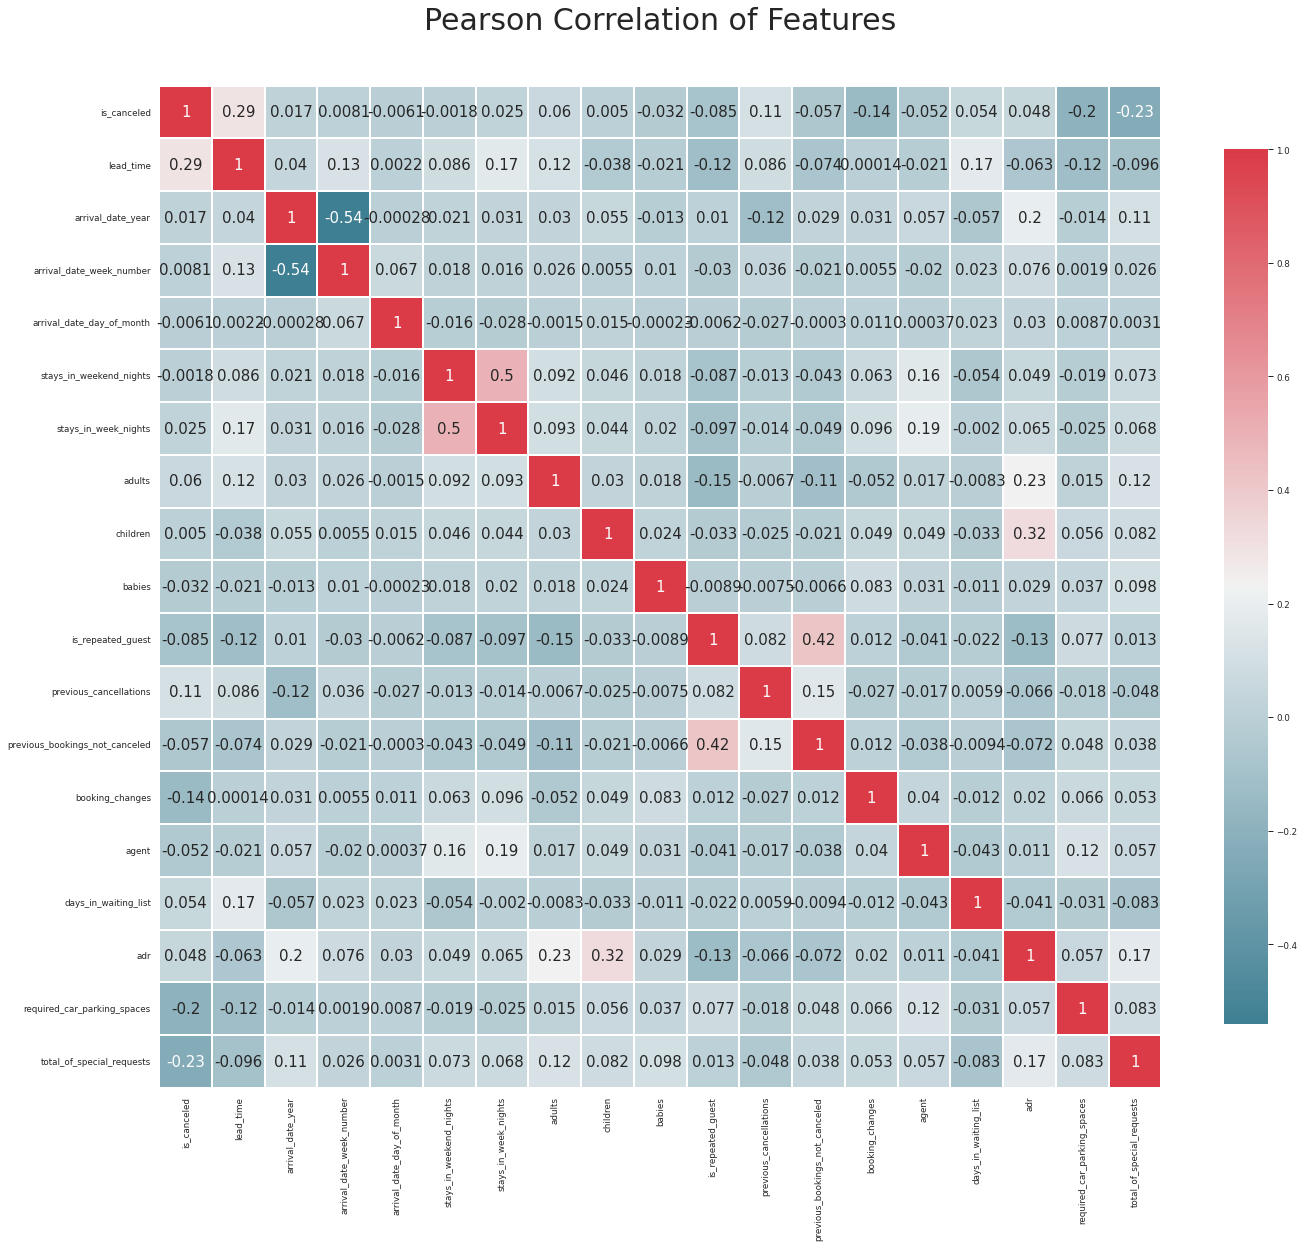

In [26]:
correlation_heatmap(df[NUMERICAL_COLS])

We do not see high correlation between features

### Feature imporatance/ Selection using RForrest

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)



rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [29]:
# Prediction
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8944635229081163

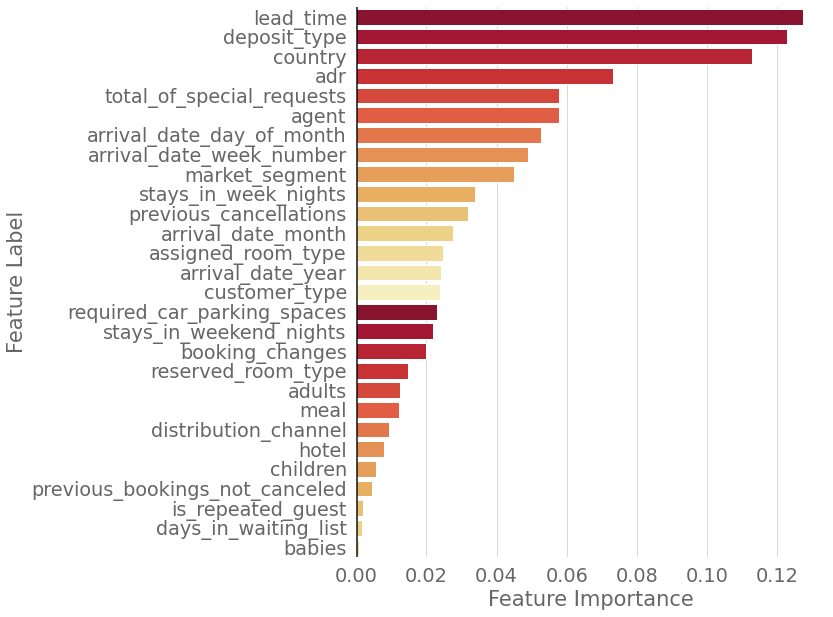

In [30]:
# Get feature importance
selected_features = X.columns.to_list()
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = rf.feature_importances_

# Sort by feature importance
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False)

# Set graph style
sns.set(font_scale = 1.75)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Set figure size and create barplot
f, ax = plt.subplots(figsize=(12, 9))
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('YlOrRd', 15)),  data = feature_importance)

# Generate a bolded horizontal line at y = 0
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7)

# Turn frame off
ax.set_frame_on(False)

# Tight layout
plt.tight_layout()

### Recursive Feature Extraction

In [31]:
from sklearn.feature_selection import RFE


rfe_random_forrest = RFE(estimator=RandomForestClassifier(), n_features_to_select=20, step=2, verbose=1)

rfe_random_forrest.fit(X_train, y_train)
random_forrest_mask = rfe_random_forrest.support_

Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.


In [32]:
result = dict(zip(X.columns, rfe_random_forrest.ranking_))
pd.concat([pd.Series(result.keys()), pd.Series(result.values())], axis=1)

,0,1
0,hotel,3
1,lead_time,1
2,arrival_date_year,1
3,arrival_date_month,1
4,arrival_date_week_number,1
5,arrival_date_day_of_month,1
6,stays_in_weekend_nights,1
7,stays_in_week_nights,1
8,adults,1
9,children,3


In [33]:
# Features that were dropped by RandomForrest

list(df.drop('is_canceled', axis=1).columns[~random_forrest_mask])

['hotel',
 'children',
 'babies',
 'meal',
 'distribution_channel',
 'is_repeated_guest',
 'previous_bookings_not_canceled',
 'days_in_waiting_list']

Columns with values > 1 are less important and were rejected while fitting the model<br>
We can see that features Babies & days_in_waiting_list were rejected first by the model<br><br>

Even though feature year was not dropped by the model, we will still drop it as it will not contribute to prediction

In [34]:
from sklearn.linear_model import LogisticRegression


rfe_log_reg = RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=20, step=2, verbose=1)

rfe_log_reg.fit(X_train, y_train)
log_reg_mask = rfe_log_reg.support_

Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.


In [35]:
result = dict(zip(X.columns, rfe_log_reg.ranking_))
#pd.concat([pd.Series(result.keys()), pd.Series(result.values())], axis=1)
result

{'hotel': 1,
 'lead_time': 3,
 'arrival_date_year': 4,
 'arrival_date_month': 1,
 'arrival_date_week_number': 3,
 'arrival_date_day_of_month': 5,
 'stays_in_weekend_nights': 1,
 'stays_in_week_nights': 1,
 'adults': 1,
 'children': 1,
 'babies': 1,
 'meal': 2,
 'country': 1,
 'market_segment': 1,
 'distribution_channel': 1,
 'is_repeated_guest': 1,
 'previous_cancellations': 1,
 'previous_bookings_not_canceled': 1,
 'reserved_room_type': 1,
 'assigned_room_type': 1,
 'booking_changes': 1,
 'deposit_type': 1,
 'agent': 5,
 'days_in_waiting_list': 4,
 'customer_type': 1,
 'adr': 2,
 'required_car_parking_spaces': 1,
 'total_of_special_requests': 1}

In [36]:
# Features that were dropped by LogisticRegression

df.drop('is_canceled', axis=1).columns[~log_reg_mask]

Index(['lead_time', 'arrival_date_year', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'agent', 'days_in_waiting_list',
       'adr'],
      dtype='object')

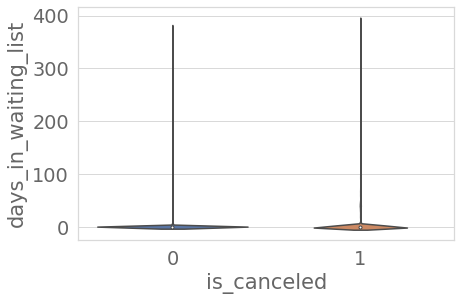

In [37]:
_ = sns.violinplot(data=df_hotel, y='days_in_waiting_list', x='is_canceled')

### 4. Find out the best Model

In [38]:
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder
from feature_engine.imputation import (
    AddMissingIndicator,
    CategoricalImputer,
    MeanMedianImputer,
)
from feature_engine.selection import DropFeatures
from feature_engine.transformation import LogTransformer
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Binarizer, MinMaxScaler

from sklearn.base import BaseEstimator, TransformerMixin

### Create Mappings

In [39]:
mapping_room_type = dict()
for i, room in enumerate(sorted(list(df_hotel['assigned_room_type'].unique()))):
    mapping_room_type[room] = i
mapping_room_type

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'P': 11}

In [40]:
mapping_month = {
    'July' : 7, 'August' : 8, 'September' : 9, 'October': 10, 'November' : 11, 'December' : 12,
       'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4, 'May' : 5, 'June' : 6
}

In [41]:
encode_columns = ['country', 'market_segment','distribution_channel', 
                  'deposit_type', 'customer_type']

In [42]:
drop_features = ['hotel','children','babies','meal','arrival_date_year','arrival_date_week_number',
                 'company', 'reservation_status', 'reservation_status_date']

In [43]:
# Mapper class to map Categorical Features

class Mapper(BaseEstimator, TransformerMixin):
    """Categorical variable mapper."""

    def __init__(self, variables: List[str], mappings: dict):

        if not isinstance(variables, list):
            raise ValueError("variables should be a list")

        self.variables = variables
        self.mappings = mappings

    def fit(self, X: pd.DataFrame, y: pd.Series = None):
        # we need the fit statement to accomodate the sklearn pipeline
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        for feature in self.variables:
            X[feature] = X[feature].map(self.mappings)

        return X

In [44]:
def CreatePipe():

    hotel_pipe = Pipeline(
        [
            # impute categorical variables with string missing
            (
                "missing_imputation",
                CategoricalImputer(
                    imputation_method="missing",
                    variables='country',
                ),
            ),
            # add missing indicator/ Creates a new binary column indicating 1 for missing values
            (
                "missing_indicator",
                AddMissingIndicator(variables=['agent']),
            ),
            # Impute median
            (
                "mean_imputation",
                MeanMedianImputer(
                    imputation_method="median",
                    variables=['agent'],
                ),
            ),

            ("drop_features", DropFeatures(features_to_drop=drop_features)),
            #("log", LogTransformer(variables='adr')),
            # Encode Categorical Features
            (
                "categorical_encoder",
                OrdinalEncoder(
                    encoding_method="ordered",
                    variables=encode_columns,
                ),
            ),
            # Custom Mapper Functions
            (
                "mapper_month",
                Mapper(
                    variables=['arrival_date_month'],
                    mappings=mapping_month,
                ),
            ),
            (
                "mapper_room_type",
                Mapper(
                    variables=['reserved_room_type', 'assigned_room_type'],
                    mappings=mapping_room_type,
                ),
            ),

            # Scaling
            (
                "scaler",
                SklearnTransformerWrapper(
                    transformer=MinMaxScaler(),
                    variables=['lead_time', 'days_in_waiting_list', 'adr'],
                ),
            )

        ])
    
    return hotel_pipe


### Evaluation Metrics

In [45]:
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score

# More Focus on Recall (Minimizing False Negatives)
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)



def evaluate_model(X, y, model):
    #cv = StratifiedKFold(n_splits=10, random_state=123)
    
    #metric = make_scorer(f2_measure)
    
    pipe = CreatePipe()
    
    X = pipe.fit_transform(X,y)
    
    scores = cross_val_score(model, X.values, y, scoring='roc_auc', cv=6, n_jobs=-1)
    return scores

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV

In [47]:
X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

def get_models():
    models, names = list(), list()
    
    # LR
    models.append(LogisticRegression(solver='liblinear')) 
    names.append('LR')
    
    # SVM
    """ 
    models.append(SVC(gamma='scale'))
    names.append('SVM')"""
    
    # Bagging 
    models.append(BaggingClassifier(n_estimators=100)) 
    names.append('BAG')
    
    # RF 
    models.append(RandomForestClassifier(n_estimators=100)) 
    names.append('RF')
    
    # GBM 
    models.append(GradientBoostingClassifier(n_estimators=100)) 
    names.append('GBM')
    return models, names

models, names = get_models()
results = list()

for i in range(len(models)):
    scores = evaluate_model(X_train, y_train, models[i])
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.883 (0.003)
>BAG 0.953 (0.001)
>RF 0.956 (0.001)
>GBM 0.926 (0.002)


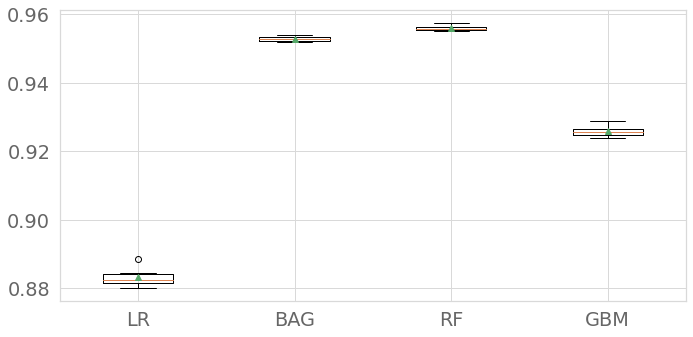

In [48]:
plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

### Random Forrest Algorithm outperforms other models also having nearly same scores(low std deviation) for different splits in the cross validation(as seen from the box plot)

### Checking the models accuracy with balanced weights due to imbalance in target classes

In [49]:
from sklearn.model_selection import train_test_split

X = df_hotel.drop('is_canceled', axis=1)
y = df_hotel['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

pipe = CreatePipe()
X_train = pipe.fit_transform(X_train, y_train)
X_test = pipe.fit_transform(X_test, y_test)

In [50]:
rf_model = RandomForestClassifier(n_estimators=1000, class_weight='balanced', oob_score=True)

rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)

print(f"Training accuracy :{accuracy_score(y_train, y_pred_train)}")
print(f"Validation accuracy : {rf_model.oob_score_}")

Training accuracy :0.9957911047826451
Validation accuracy : 0.8938248597034928


#### We can see great improvement in training accuracy after using balanced class weights

### Looks like our model has overfitted, lets check the testing Accuracy

In [51]:
y_pred = rf_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.8342826032331015

#### Our Model has overfitted the training examples

### Fine Tuning

In [52]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(class_weight='balanced', oob_score = True)
params = {
                'max_depth' : [1,2,3,4,5,6],
               'min_samples_leaf' : [0.01,0.02,0.04,0.06],
                'max_features' : [0.1,0.2,0.4,0.8],
                'n_estimators' : [100,150,200,250,300,500]
                
        }

cv = StratifiedKFold(n_splits=3, random_state=123)

rf_random_search_cv = RandomizedSearchCV(estimator=rf,
                          param_distributions=params,
                           n_iter=50,
                          cv=cv,
                          scoring='roc_auc',
                          n_jobs=-1,
                           verbose=1
                          )

rf_random_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 14.1min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=123, shuffle=False),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    oob_score=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6],
                                        'max_features': [0.1, 0.2, 0.4, 0.8],
                                        'min_samples_leaf': [0.01, 0.02, 0.04,
                                                             0.06],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300, 500]},
                   scoring='roc_auc', verbose=1)

In [53]:
rf_random_search_cv.best_params_

{'n_estimators': 500,
 'min_samples_leaf': 0.01,
 'max_features': 0.2,
 'max_depth': 6}

In [54]:
random_best_estimator = rf_random_search_cv.best_estimator_
y_pred = random_best_estimator.predict(X_test)
accuracy_score(y_test, y_pred)

0.8220537733478516

### Selecting parameters from Random Search & more Exploration using Grid Search

In [55]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier(class_weight='balanced', 
                            oob_score = True, 
                             n_estimators = 500,
                             min_samples_leaf= 3,
                             max_features= 'sqrt',
                           max_depth=8)



params = {
                'min_samples_leaf': [2,3,4]
                
        }

rf_cv = GridSearchCV(estimator=rf,
                          param_grid=params,
                          cv=3,
                          scoring='roc_auc',
                          n_jobs=-1,
                           verbose=1
                          )

rf_cv.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.3min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=8, max_features='sqrt',
                                              min_samples_leaf=3,
                                              n_estimators=500,
                                              oob_score=True),
             n_jobs=-1, param_grid={'min_samples_leaf': [2, 3, 4]},
             scoring='roc_auc', verbose=1)

### Testing accuracy

In [56]:
print(rf_cv.best_params_)
y_pred = rf_cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

{'min_samples_leaf': 2}


0.824482787503141

Normalized confusion matrix
[[0.92 0.08]
 [0.34 0.66]]


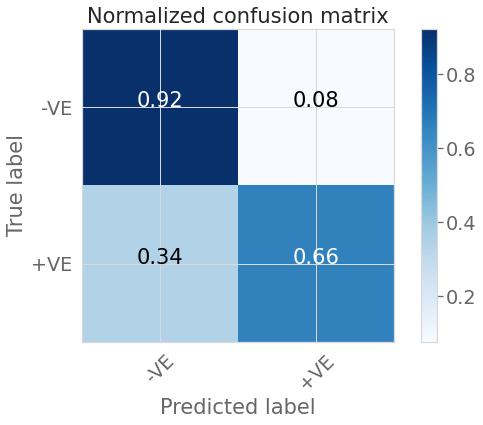

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['-VE','+VE']
np.set_printoptions(precision=2)


plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     15033
           1       0.83      0.66      0.74      8845

    accuracy                           0.82     23878
   macro avg       0.83      0.79      0.80     23878
weighted avg       0.83      0.82      0.82     23878

